# Compare methods for creating image representations

In [1]:
%matplotlib inline

In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from skimage.util import img_as_float, img_as_uint
from scipy import ndimage
from scipy.stats import multivariate_normal

import imagerep

### Parameters

In [3]:
# Path to file containing Zimmer data
IN_FPATH = '/home/mn2822/Desktop/WormTracking/data/zimmer/mCherry_v00065-01581.hdf5'

### Load Zimmer data

In [4]:
# Index of frame to use
t_frame = 500

with h5py.File(IN_FPATH, 'r') as f:
    dset = f.get('mCherry')
    frame = dset[t_frame, 0, :, :, :]
    frame = np.moveaxis(frame, [0, 1, 2], [2, 1, 0])

### Select section of frame for test image

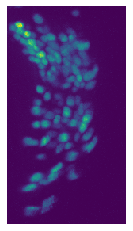

In [5]:
# Section of XY plane where head is found
head_x = (500, 650)
head_y = (250, 525)
head_z = (0, 33)

# Extract section
img = frame[head_x[0]:head_x[1], head_y[0]:head_y[1], head_z[0]:head_z[1]]
img = img_as_float(img)

# Display max projection
plt.imshow(np.max(img, 2).T);
plt.axis('off');

In [6]:
def reconstruct_image(means, covs, weights, shape, tol=1e-5):
    
    img_recon = np.zeros(shape)
    for k in range(len(means)):
    
        cell = weights[k] * imagerep.get_gaussian_filter(covs[k], (15, 15, 5))
        img_recon += imagerep.get_patch_image(cell, shape, means[k])
    
    return img_recon

### Compute MSE for different numbers of MP iterations

In [13]:
cov = np.diag([8.0, 8.0, 1.5])
n_pixels = img.shape[0] * img.shape[1] * img.shape[2]

n_iter = range(50, 750, 50)
err = []

for n in n_iter:
    
    pts, weights, debug = imagerep.mp_gaussian(img, cov, n)
    covs = [cov for i in range(len(pts))]
    img_recon = reconstruct_image(pts, covs, weights, img.shape)
    
    err.append(np.sum((img_recon - img) ** 2) / n_pixels)

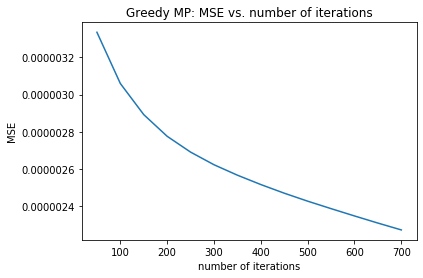

In [16]:
plt.plot(n_iter, err)
plt.xlabel('number of iterations')
plt.ylabel('MSE')
plt.title('Greedy MP: MSE vs. number of iterations')
plt.savefig('mp_err.png')